<a href="https://colab.research.google.com/github/moharamfatema/graduation-project/blob/main/transfer_learning_transformer_smart_city.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Loading


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip install -qU tensorflow-datasets

     |████████████████████████████████| 4.7 MB 5.3 MB/s 


In [ ]:
 #! pip install kaggle

In [ ]:
 #! mkdir ~/.kaggle drive/MyDrive/Smart-City-dataset

In [ ]:

# ! cp kaggle.json ~/.kaggle/

In [ ]:
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download -d toluwaniaremu/smartcity-cctv-violence-detection-dataset-scvd -p drive/MyDrive/Smart-City-dataset

In [ ]:
# %mkdir ./Smart-City-dataset

The syntax of the command is incorrect.


In [ ]:
 ! Expand-Archive ./smartcity-cctv-violence-detection-dataset-scvd.zip -d ./smart-city-dataset/videos

'Expand-Archive' is not recognized as an internal or external command,
operable program or batch file.


#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as tfl
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

##Define Constants

In [ ]:
ROOT_PATH = './Smart-City-dataset/videos/SCVD/videos'

WEAPON_VIOLENCE_PATH = ROOT_PATH + '/Weapon Violence'
VIOLENCE_PATH = ROOT_PATH + '/violence video cleaned'
NORMAL_PATH = ROOT_PATH + '/Non-Violence Videos'

print(os.listdir(NORMAL_PATH)[-1])
print(os.listdir(VIOLENCE_PATH)[-1])
print(os.listdir(WEAPON_VIOLENCE_PATH))
# define output paths

OUT_PATH = './transformers/preprocessed_data'

nv99.mov
V99.mp4
['WV1.mp4', 'WV10.mp4', 'WV100.mp4', 'WV101.mp4', 'WV102.mp4', 'WV103.mp4', 'WV104.mp4', 'WV105.mp4', 'WV106.mp4', 'WV107.mp4', 'WV108.mp4', 'WV109.mp4', 'WV11.mp4', 'WV110.mp4', 'WV111.mp4', 'WV112.mp4', 'WV113.mp4', 'WV114.mp4', 'WV115.mp4', 'WV116.mp4', 'WV118.mp4', 'WV119.mp4', 'WV12.mp4', 'WV120.mp4', 'WV121.mp4', 'WV122.mp4', 'WV123.mp4', 'WV124.mp4', 'WV13.mp4', 'WV14.mp4', 'WV15.mp4', 'WV16.mp4', 'WV17.mp4', 'WV18.mp4', 'WV19.mp4', 'WV2.mp4', 'WV20.mp4', 'WV21.mp4', 'WV22.mp4', 'WV23.mp4', 'WV24.mp4', 'WV25.mp4', 'WV26.mp4', 'WV27.mp4', 'WV28.mp4', 'WV29.mp4', 'WV3.mp4', 'WV30.mp4', 'WV31.mp4', 'WV32.mp4', 'WV33.mp4', 'WV34.mp4', 'WV35.mp4', 'WV36.mp4', 'WV37.mp4', 'WV38.mp4', 'WV39.mp4', 'WV4.mp4', 'WV40.mp4', 'WV41.mp4', 'WV42.mp4', 'WV43.mp4', 'WV44.mp4', 'WV45.mp4', 'WV46.mp4', 'WV47.mp4', 'WV48.mp4', 'WV49.mp4', 'WV5.mp4', 'WV50.mp4', 'WV51.mp4', 'WV52.mp4', 'WV53.mp4', 'WV54.mp4', 'WV55.mp4', 'WV56.mp4', 'WV57.mp4', 'WV58.mp4', 'WV59.mp4', 'WV6.mp4', 'WV6

#Data preprocessing

In [ ]:
IMG_SIZE = 256

def load_video(path, dimension=IMG_SIZE, packet_length=20):
    cap = cv2.VideoCapture(path)
    data = []
    frames = []
    try:
        i = -1
        while True:
            i += 1
            if i % 2 != 0:
                continue
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (dimension, dimension), interpolation = cv2.INTER_AREA)
            frames.append(frame)

            if len(frames) == packet_length:
              data.append(frames)
              frames.pop()[0]
    finally:
        cap.release()
    return np.array(data)


In [ ]:
def build_feature_extractor(dimension=IMG_SIZE):
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(dimension, dimension,3)
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((dimension, dimension,3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [ ]:
feature_extractor = build_feature_extractor()

In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 256

EPOCHS = 5


def prepare_all_videos(df, root_dir=ROOT_PATH):
    video_paths = df["video_name"].values.tolist()
    labels = df["label"].values

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(len(df), MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for k, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        if labels[k] ==0:
          Path = NORMAL_PATH
        elif labels[k] == 1:
          Path = VIOLENCE_PATH
        else:
          Path = WEAPON_VIOLENCE_PATH  
        packets = load_video(os.path.join(root_dir,Path, path))
        # Pad shorter videos.
        for idx, frames in enumerate(packets):
          if len(frames) < MAX_SEQ_LENGTH:
              diff = MAX_SEQ_LENGTH - len(frames)
              padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
              frames = np.concatenate((frames, padding))

          frames = frames[None, ...]

          # Initialize placeholder to store the features of the current video.
          temp_frame_features = np.zeros(
              shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
          )

          # Extract features from the frames of the current video.
          for i, batch in enumerate(frames):
              video_length = batch.shape[0]
              length = min(MAX_SEQ_LENGTH, video_length)
              for j in range(length):
                  if np.mean(batch[j, :]) > 0.0:
                      temp_frame_features[i, j, :] = feature_extractor.predict(
                          batch[None, j, :]
                      )

                  else:
                      temp_frame_features[i, j, :] = 0.0

          frame_features[k,] = temp_frame_features.squeeze()
    print(frame_features.shape)

    return frame_features, labels

In [ ]:
def process_paths(normal, violence, weapon_violence):
  subset = min(len(normal),len(violence), len(weapon_violence))

  y = np.concatenate([np.zeros(subset), np.ones(subset), np.full(subset, 2)], axis = 0)
  x = np.concatenate([normal[:subset], violence[:subset], weapon_violence[:subset]], axis = 0)

  print((x.shape, y.shape))

  #shuffle
  per = np.random.permutation(len(x))

  x = x[per]
  y = y[per]
  y = y.astype(int)

  y = np.expand_dims(y, -1)

  return x, y

In [ ]:

def save_datasets(
    save_path: str
  ) -> np.ndarray:
  
  normal_random = np.random.permutation(100)
  violence_random = np.random.permutation(100)
  weapon_violence_random = np.random.permutation(100)

  # train
  normal_data = np.array(os.listdir(f'{ROOT_PATH}/Non-Violence Videos'))[normal_random[:70]]
  violence_data = np.array(os.listdir(f'{ROOT_PATH}/violence video cleaned'))[violence_random[:70]]
  weapon_violence_data = np.array(os.listdir(f'{ROOT_PATH}/Weapon Violence'))[ weapon_violence_random [:70]] 

  x, y = process_paths(normal_data, violence_data, weapon_violence_data)

  del normal_data
  del violence_data
  del weapon_violence_data

  x = x.reshape(-1)
  y = y.reshape(-1)

  data_dict = {
    "video_name":x,
    "label":y,
  }

  df = pd.DataFrame.from_dict(data_dict)

  x, y = prepare_all_videos(df)
  print ("THIS BATCH IS FINE TRAIN")

  del df
  del data_dict

  np.save(f'{save_path}/x_train_new',x)
  np.save(f'{save_path}/y_train_new',y)

  del x
  del y

  # validation
  normal_data = np.array(os.listdir(f'{ROOT_PATH}/Non-Violence Videos'))[normal_random[70:85]]
  violence_data = np.array(os.listdir(f'{ROOT_PATH}/violence video cleaned'))[violence_random[70:85]]
  weapon_violence_data = np.array(os.listdir(f'{ROOT_PATH}/Weapon Violence'))[ weapon_violence_random [70:85]] 

  x, y = process_paths(normal_data, violence_data, weapon_violence_data)

  del normal_data
  del violence_data

  x = x.reshape(-1)
  y = y.reshape(-1)

  data_dict = {
    "video_name":x,
    "label":y,
  }

  df = pd.DataFrame.from_dict(data_dict)

  x, y = prepare_all_videos(df)
  print("VAL IS FINE")

  del df
  del data_dict

  np.save(f'{save_path}/x_val_new',x)
  np.save(f'{save_path}/y_val_new',y)

  del x
  del y

  # test
  normal_data = np.array(os.listdir(f'{ROOT_PATH}/Non-Violence Videos'))[normal_random[85:]]
  violence_data = np.array(os.listdir(f'{ROOT_PATH}/violence video cleaned'))[violence_random[85:]]
  weapon_violence_data = np.array(os.listdir(f'{ROOT_PATH}/Weapon Violence'))[ weapon_violence_random [85:]] 
  x, y = process_paths(normal_data, violence_data, weapon_violence_data)

  del normal_data
  del violence_data
  del weapon_violence_data

  x = x.reshape(-1)
  y = y.reshape(-1)

  data_dict = {
    "video_name":x,
    "label":y,
  }

  df = pd.DataFrame.from_dict(data_dict)

  x, y = prepare_all_videos(df)
  print("TESTIS FINE")
  del df
  del data_dict

  np.save(f'{save_path}/x_test_new',x)
  np.save(f'{save_path}/y_test_new',y)

  del x
  del y

In [ ]:
! dir

 Volume in drive C has no label.
 Volume Serial Number is D8B5-D7E8

 Directory of C:\Users\MOhanad\Downloads

10/24/2022  01:53 PM    <DIR>          .
10/24/2022  01:53 PM    <DIR>          ..
10/24/2022  01:24 PM    <DIR>          .ipynb_checkpoints
10/19/2022  10:18 AM         3,999,808 AnyDesk.exe
10/20/2022  05:04 PM           374,605 Copy_of_smart_city_trial (1).ipynb
10/24/2022  01:53 PM            31,151 Copy_of_smart_city_trial (2).ipynb
10/20/2022  02:19 PM           375,561 Copy_of_smart_city_trial.ipynb
10/24/2022  01:34 PM    <DIR>          env
10/24/2022  12:22 PM           394,240 gcapi.dll
10/20/2022  02:47 PM       396,601,896 pycharm-community-2022.2.3.exe
10/20/2022  02:59 PM        28,978,512 python-3.10.8-amd64.exe
10/24/2022  01:41 PM                98 requirements.txt.txt
10/24/2022  01:49 PM    <DIR>          Smart-City-dataset
10/23/2022  02:52 PM     2,059,001,546 Smart-City-dataset-20221023T124854Z-001.zip
10/24/2022  01:53 PM    <DIR>          transformers
1

In [ ]:
save_datasets(OUT_PATH)

((210,), (210,))
(210, 20, 1024)
THIS BATCH IS FINE TRAIN
((45,), (45,))
(45, 20, 1024)
VAL IS FINE
((45,), (45,))
(45, 20, 1024)
TESTIS FINE


##Loading datasets from preproccessed data

In [ ]:
# Load Data

def load_x_y(
    load_which: str = 'train', 
  ):
  violence_data = None
  normal_data = None
  weapon_violence_data = None
  if load_which == 'train':
    x = np.load(f'{OUT_PATH}/x_train.npy')
    y  = np.load(f'{OUT_PATH}/y_train.npy')

  elif load_which == 'validation':
    x = np.load(f'{OUT_PATH}/x_val.npy')
    y  = np.load(f'{OUT_PATH}/y_val.npy')

  elif load_which == 'test':
    x = np.load(f'{OUT_PATH}/x_test.npy')
    y  = np.load(f'{OUT_PATH}/y_test.npy')

  print(f'y shape = {y.shape}')
  print(f'x shape = {x.shape}')

  return x, y

In [ ]:
x_train, y_train = load_x_y('train')

x_val, y_val = load_x_y('validation')

x_test, y_test = load_x_y('test')


y shape = (210,)
x shape = (210, 20, 1024)
y shape = (45,)
x shape = (45, 20, 1024)
y shape = (45,)
x shape = (45, 20, 1024)


#Model

In [ ]:
class PositionalEmbedding(tfl.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = tfl.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [ ]:
class TransformerEncoder(tfl.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tfl.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [tfl.Dense(dense_dim, activation=tf.nn.gelu), tfl.Dense(embed_dim),]
        )
        self.layernorm_1 = tfl.LayerNormalization()
        self.layernorm_2 = tfl.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = 3

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = tfl.GlobalMaxPooling1D()(x)
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = f'{OUT_PATH}/data'
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        x_train,
        y_train,
        validation_data= (x_val, y_val),
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model, history

In [ ]:
del trained_model

NameError: name 'trained_model' is not defined

In [ ]:
EPOCHS = 1000

In [ ]:
trained_model, history  = run_experiment()

Epoch 1/1000
7/7 [==============================] - ETA: 0s - loss: 3.5181 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 1.37196, saving model to ./transformers/preprocessed_data\data
7/7 [==============================] - 6s 656ms/step - loss: 3.5181 - accuracy: 0.3333 - val_loss: 1.3720 - val_accuracy: 0.3333
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.2334 - accuracy: 0.3333
Epoch 2: val_loss did not improve from 1.37196
7/7 [==============================] - 4s 574ms/step - loss: 2.2334 - accuracy: 0.3333 - val_loss: 1.7738 - val_accuracy: 0.3333
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.2342 - accuracy: 0.3286
Epoch 3: val_loss improved from 1.37196 to 1.22783, saving model to ./transformers/preprocessed_data\data
7/7 [==============================] - 4s 593ms/step - loss: 2.2342 - accuracy: 0.3286 - val_loss: 1.2278 - val_accuracy: 0.3333
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.8386 -

7/7 [==============================] - ETA: 0s - loss: 1.1535 - accuracy: 0.3286
Epoch 30: val_loss did not improve from 1.10934
7/7 [==============================] - 4s 547ms/step - loss: 1.1535 - accuracy: 0.3286 - val_loss: 1.1108 - val_accuracy: 0.3333
Epoch 31/1000
7/7 [==============================] - ETA: 0s - loss: 1.1349 - accuracy: 0.3286
Epoch 31: val_loss improved from 1.10934 to 1.10521, saving model to ./transformers/preprocessed_data\data
7/7 [==============================] - 4s 585ms/step - loss: 1.1349 - accuracy: 0.3286 - val_loss: 1.1052 - val_accuracy: 0.3333
Epoch 32/1000
7/7 [==============================] - ETA: 0s - loss: 1.1428 - accuracy: 0.3286
Epoch 32: val_loss did not improve from 1.10521
7/7 [==============================] - 4s 546ms/step - loss: 1.1428 - accuracy: 0.3286 - val_loss: 1.1118 - val_accuracy: 0.3333
Epoch 33/1000
7/7 [==============================] - ETA: 0s - loss: 1.1451 - accuracy: 0.3333
Epoch 33: val_loss improved from 1.10521 to 

7/7 [==============================] - ETA: 0s - loss: 1.1070 - accuracy: 0.3571
Epoch 59: val_loss did not improve from 1.09899
7/7 [==============================] - 4s 521ms/step - loss: 1.1070 - accuracy: 0.3571 - val_loss: 1.1009 - val_accuracy: 0.3333
Epoch 60/1000
7/7 [==============================] - ETA: 0s - loss: 1.1477 - accuracy: 0.2952
Epoch 60: val_loss did not improve from 1.09899
7/7 [==============================] - 4s 523ms/step - loss: 1.1477 - accuracy: 0.2952 - val_loss: 1.1024 - val_accuracy: 0.3333
Epoch 61/1000
7/7 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.2952
Epoch 61: val_loss did not improve from 1.09899
7/7 [==============================] - 4s 527ms/step - loss: 1.1414 - accuracy: 0.2952 - val_loss: 1.1075 - val_accuracy: 0.3333
Epoch 62/1000
7/7 [==============================] - ETA: 0s - loss: 1.1467 - accuracy: 0.3238
Epoch 62: val_loss did not improve from 1.09899
7/7 [==============================] - 4s 528ms/step - 

7/7 [==============================] - ETA: 0s - loss: 1.1147 - accuracy: 0.3524
Epoch 89: val_loss did not improve from 1.09899
7/7 [==============================] - 4s 513ms/step - loss: 1.1147 - accuracy: 0.3524 - val_loss: 1.1185 - val_accuracy: 0.3333
Epoch 90/1000
7/7 [==============================] - ETA: 0s - loss: 1.1226 - accuracy: 0.3476
Epoch 90: val_loss did not improve from 1.09899
7/7 [==============================] - 4s 505ms/step - loss: 1.1226 - accuracy: 0.3476 - val_loss: 1.1060 - val_accuracy: 0.3333
Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 1.1431 - accuracy: 0.3476
Epoch 91: val_loss did not improve from 1.09899
7/7 [==============================] - 3s 501ms/step - loss: 1.1431 - accuracy: 0.3476 - val_loss: 1.1029 - val_accuracy: 0.3333
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 1.1371 - accuracy: 0.3143
Epoch 92: val_loss did not improve from 1.09899
7/7 [==============================] - 4s 516ms/step - 

Epoch 119/1000
7/7 [==============================] - ETA: 0s - loss: 1.1642 - accuracy: 0.3095
Epoch 119: val_loss did not improve from 1.09870
7/7 [==============================] - 3s 494ms/step - loss: 1.1642 - accuracy: 0.3095 - val_loss: 1.1132 - val_accuracy: 0.3333
Epoch 120/1000
7/7 [==============================] - ETA: 0s - loss: 1.1228 - accuracy: 0.3286
Epoch 120: val_loss did not improve from 1.09870
7/7 [==============================] - 3s 497ms/step - loss: 1.1228 - accuracy: 0.3286 - val_loss: 1.1383 - val_accuracy: 0.3333
Epoch 121/1000
7/7 [==============================] - ETA: 0s - loss: 1.1651 - accuracy: 0.3143
Epoch 121: val_loss did not improve from 1.09870
7/7 [==============================] - 3s 504ms/step - loss: 1.1651 - accuracy: 0.3143 - val_loss: 1.1175 - val_accuracy: 0.3333
Epoch 122/1000
7/7 [==============================] - ETA: 0s - loss: 1.1345 - accuracy: 0.2762
Epoch 122: val_loss did not improve from 1.09870
7/7 [============================

Epoch 149/1000
7/7 [==============================] - ETA: 0s - loss: 1.1084 - accuracy: 0.3286
Epoch 149: val_loss did not improve from 1.09870
7/7 [==============================] - 4s 515ms/step - loss: 1.1084 - accuracy: 0.3286 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 150/1000
7/7 [==============================] - ETA: 0s - loss: 1.1271 - accuracy: 0.2667
Epoch 150: val_loss did not improve from 1.09870
7/7 [==============================] - 4s 501ms/step - loss: 1.1271 - accuracy: 0.2667 - val_loss: 1.1018 - val_accuracy: 0.3333
Epoch 151/1000
7/7 [==============================] - ETA: 0s - loss: 1.1187 - accuracy: 0.3143
Epoch 151: val_loss did not improve from 1.09870
7/7 [==============================] - 4s 509ms/step - loss: 1.1187 - accuracy: 0.3143 - val_loss: 1.1012 - val_accuracy: 0.3333
Epoch 152/1000
7/7 [==============================] - ETA: 0s - loss: 1.1105 - accuracy: 0.3000
Epoch 152: val_loss did not improve from 1.09870
7/7 [============================

Epoch 179/1000
7/7 [==============================] - ETA: 0s - loss: 1.1067 - accuracy: 0.3286
Epoch 179: val_loss did not improve from 1.09870
7/7 [==============================] - 3s 492ms/step - loss: 1.1067 - accuracy: 0.3286 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 180/1000
7/7 [==============================] - ETA: 0s - loss: 1.1068 - accuracy: 0.3381
Epoch 180: val_loss did not improve from 1.09870
7/7 [==============================] - 3s 489ms/step - loss: 1.1068 - accuracy: 0.3381 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 181/1000
7/7 [==============================] - ETA: 0s - loss: 1.1049 - accuracy: 0.3381
Epoch 181: val_loss did not improve from 1.09870
7/7 [==============================] - 3s 490ms/step - loss: 1.1049 - accuracy: 0.3381 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 182/1000
7/7 [==============================] - ETA: 0s - loss: 1.1090 - accuracy: 0.3190
Epoch 182: val_loss did not improve from 1.09870
7/7 [============================

Epoch 209/1000
7/7 [==============================] - ETA: 0s - loss: 1.1013 - accuracy: 0.3381
Epoch 209: val_loss did not improve from 1.09868
7/7 [==============================] - 4s 511ms/step - loss: 1.1013 - accuracy: 0.3381 - val_loss: 1.1022 - val_accuracy: 0.3333
Epoch 210/1000
7/7 [==============================] - ETA: 0s - loss: 1.1310 - accuracy: 0.3000
Epoch 210: val_loss did not improve from 1.09868
7/7 [==============================] - 4s 508ms/step - loss: 1.1310 - accuracy: 0.3000 - val_loss: 1.1000 - val_accuracy: 0.3333
Epoch 211/1000
7/7 [==============================] - ETA: 0s - loss: 1.1169 - accuracy: 0.3286
Epoch 211: val_loss did not improve from 1.09868
7/7 [==============================] - 4s 514ms/step - loss: 1.1169 - accuracy: 0.3286 - val_loss: 1.1086 - val_accuracy: 0.3333
Epoch 212/1000
7/7 [==============================] - ETA: 0s - loss: 1.1179 - accuracy: 0.3000
Epoch 212: val_loss did not improve from 1.09868
7/7 [============================

Epoch 239/1000
7/7 [==============================] - ETA: 0s - loss: 1.1015 - accuracy: 0.3476
Epoch 239: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 505ms/step - loss: 1.1015 - accuracy: 0.3476 - val_loss: 1.1073 - val_accuracy: 0.3333
Epoch 240/1000
7/7 [==============================] - ETA: 0s - loss: 1.1032 - accuracy: 0.3381
Epoch 240: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 504ms/step - loss: 1.1032 - accuracy: 0.3381 - val_loss: 1.1080 - val_accuracy: 0.3333
Epoch 241/1000
7/7 [==============================] - ETA: 0s - loss: 1.1207 - accuracy: 0.3524
Epoch 241: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 504ms/step - loss: 1.1207 - accuracy: 0.3524 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 242/1000
7/7 [==============================] - ETA: 0s - loss: 1.1170 - accuracy: 0.3429
Epoch 242: val_loss did not improve from 1.09862
7/7 [============================

Epoch 269/1000
7/7 [==============================] - ETA: 0s - loss: 1.1086 - accuracy: 0.3190
Epoch 269: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 507ms/step - loss: 1.1086 - accuracy: 0.3190 - val_loss: 1.1013 - val_accuracy: 0.3333
Epoch 270/1000
7/7 [==============================] - ETA: 0s - loss: 1.0960 - accuracy: 0.3571
Epoch 270: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 512ms/step - loss: 1.0960 - accuracy: 0.3571 - val_loss: 1.1002 - val_accuracy: 0.3333
Epoch 271/1000
7/7 [==============================] - ETA: 0s - loss: 1.1200 - accuracy: 0.3048
Epoch 271: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 519ms/step - loss: 1.1200 - accuracy: 0.3048 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 272/1000
7/7 [==============================] - ETA: 0s - loss: 1.1074 - accuracy: 0.3476
Epoch 272: val_loss did not improve from 1.09862
7/7 [============================

Epoch 299/1000
7/7 [==============================] - ETA: 0s - loss: 1.1132 - accuracy: 0.2857
Epoch 299: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 496ms/step - loss: 1.1132 - accuracy: 0.2857 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 300/1000
7/7 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.3190
Epoch 300: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 496ms/step - loss: 1.1198 - accuracy: 0.3190 - val_loss: 1.1076 - val_accuracy: 0.3333
Epoch 301/1000
7/7 [==============================] - ETA: 0s - loss: 1.1128 - accuracy: 0.3238
Epoch 301: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 499ms/step - loss: 1.1128 - accuracy: 0.3238 - val_loss: 1.1021 - val_accuracy: 0.3333
Epoch 302/1000
7/7 [==============================] - ETA: 0s - loss: 1.1057 - accuracy: 0.3667
Epoch 302: val_loss did not improve from 1.09862
7/7 [============================

Epoch 329/1000
7/7 [==============================] - ETA: 0s - loss: 1.1055 - accuracy: 0.3810
Epoch 329: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 497ms/step - loss: 1.1055 - accuracy: 0.3810 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 330/1000
7/7 [==============================] - ETA: 0s - loss: 1.1006 - accuracy: 0.2667
Epoch 330: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 490ms/step - loss: 1.1006 - accuracy: 0.2667 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 331/1000
7/7 [==============================] - ETA: 0s - loss: 1.1024 - accuracy: 0.3524
Epoch 331: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 487ms/step - loss: 1.1024 - accuracy: 0.3524 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 332/1000
7/7 [==============================] - ETA: 0s - loss: 1.1165 - accuracy: 0.2619
Epoch 332: val_loss did not improve from 1.09862
7/7 [============================

Epoch 359/1000
7/7 [==============================] - ETA: 0s - loss: 1.1019 - accuracy: 0.3714
Epoch 359: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 504ms/step - loss: 1.1019 - accuracy: 0.3714 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 360/1000
7/7 [==============================] - ETA: 0s - loss: 1.0840 - accuracy: 0.3905
Epoch 360: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 499ms/step - loss: 1.0840 - accuracy: 0.3905 - val_loss: 1.1012 - val_accuracy: 0.3333
Epoch 361/1000
7/7 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.3476
Epoch 361: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 497ms/step - loss: 1.1078 - accuracy: 0.3476 - val_loss: 1.1003 - val_accuracy: 0.3333
Epoch 362/1000
7/7 [==============================] - ETA: 0s - loss: 1.1039 - accuracy: 0.3429
Epoch 362: val_loss did not improve from 1.09862
7/7 [============================

Epoch 389/1000
7/7 [==============================] - ETA: 0s - loss: 1.1019 - accuracy: 0.3429
Epoch 389: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 507ms/step - loss: 1.1019 - accuracy: 0.3429 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 390/1000
7/7 [==============================] - ETA: 0s - loss: 1.1045 - accuracy: 0.3000
Epoch 390: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 507ms/step - loss: 1.1045 - accuracy: 0.3000 - val_loss: 1.1004 - val_accuracy: 0.3333
Epoch 391/1000
7/7 [==============================] - ETA: 0s - loss: 1.1048 - accuracy: 0.3095
Epoch 391: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 506ms/step - loss: 1.1048 - accuracy: 0.3095 - val_loss: 1.1000 - val_accuracy: 0.3333
Epoch 392/1000
7/7 [==============================] - ETA: 0s - loss: 1.1092 - accuracy: 0.3286
Epoch 392: val_loss did not improve from 1.09862
7/7 [============================

Epoch 419/1000
7/7 [==============================] - ETA: 0s - loss: 1.1058 - accuracy: 0.3190
Epoch 419: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 523ms/step - loss: 1.1058 - accuracy: 0.3190 - val_loss: 1.1023 - val_accuracy: 0.3333
Epoch 420/1000
7/7 [==============================] - ETA: 0s - loss: 1.1130 - accuracy: 0.2952
Epoch 420: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 505ms/step - loss: 1.1130 - accuracy: 0.2952 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 421/1000
7/7 [==============================] - ETA: 0s - loss: 1.1080 - accuracy: 0.3095
Epoch 421: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 527ms/step - loss: 1.1080 - accuracy: 0.3095 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 422/1000
7/7 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.2857
Epoch 422: val_loss did not improve from 1.09862
7/7 [============================

Epoch 449/1000
7/7 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.3143
Epoch 449: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 491ms/step - loss: 1.1148 - accuracy: 0.3143 - val_loss: 1.1058 - val_accuracy: 0.3333
Epoch 450/1000
7/7 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.2905
Epoch 450: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 497ms/step - loss: 1.1078 - accuracy: 0.2905 - val_loss: 1.1036 - val_accuracy: 0.3333
Epoch 451/1000
7/7 [==============================] - ETA: 0s - loss: 1.1102 - accuracy: 0.3333
Epoch 451: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 494ms/step - loss: 1.1102 - accuracy: 0.3333 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 452/1000
7/7 [==============================] - ETA: 0s - loss: 1.1100 - accuracy: 0.3429
Epoch 452: val_loss did not improve from 1.09862
7/7 [============================

Epoch 479/1000
7/7 [==============================] - ETA: 0s - loss: 1.1225 - accuracy: 0.3667
Epoch 479: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 504ms/step - loss: 1.1225 - accuracy: 0.3667 - val_loss: 1.1014 - val_accuracy: 0.3333
Epoch 480/1000
7/7 [==============================] - ETA: 0s - loss: 1.1240 - accuracy: 0.3429
Epoch 480: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 506ms/step - loss: 1.1240 - accuracy: 0.3429 - val_loss: 1.1075 - val_accuracy: 0.3333
Epoch 481/1000
7/7 [==============================] - ETA: 0s - loss: 1.1204 - accuracy: 0.3381
Epoch 481: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 497ms/step - loss: 1.1204 - accuracy: 0.3381 - val_loss: 1.1060 - val_accuracy: 0.3333
Epoch 482/1000
7/7 [==============================] - ETA: 0s - loss: 1.1404 - accuracy: 0.2905
Epoch 482: val_loss did not improve from 1.09862
7/7 [============================

Epoch 509/1000
7/7 [==============================] - ETA: 0s - loss: 1.1034 - accuracy: 0.3476
Epoch 509: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 490ms/step - loss: 1.1034 - accuracy: 0.3476 - val_loss: 1.1004 - val_accuracy: 0.3333
Epoch 510/1000
7/7 [==============================] - ETA: 0s - loss: 1.1106 - accuracy: 0.3238
Epoch 510: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 492ms/step - loss: 1.1106 - accuracy: 0.3238 - val_loss: 1.1029 - val_accuracy: 0.3333
Epoch 511/1000
7/7 [==============================] - ETA: 0s - loss: 1.1068 - accuracy: 0.3190
Epoch 511: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 501ms/step - loss: 1.1068 - accuracy: 0.3190 - val_loss: 1.1079 - val_accuracy: 0.3333
Epoch 512/1000
7/7 [==============================] - ETA: 0s - loss: 1.1062 - accuracy: 0.3095
Epoch 512: val_loss did not improve from 1.09862
7/7 [============================

Epoch 539/1000
7/7 [==============================] - ETA: 0s - loss: 1.1000 - accuracy: 0.3143
Epoch 539: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 498ms/step - loss: 1.1000 - accuracy: 0.3143 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 540/1000
7/7 [==============================] - ETA: 0s - loss: 1.1016 - accuracy: 0.3095
Epoch 540: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 496ms/step - loss: 1.1016 - accuracy: 0.3095 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 541/1000
7/7 [==============================] - ETA: 0s - loss: 1.1055 - accuracy: 0.3190
Epoch 541: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 494ms/step - loss: 1.1055 - accuracy: 0.3190 - val_loss: 1.0998 - val_accuracy: 0.3333
Epoch 542/1000
7/7 [==============================] - ETA: 0s - loss: 1.1067 - accuracy: 0.3190
Epoch 542: val_loss did not improve from 1.09862
7/7 [============================

Epoch 569/1000
7/7 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.3429
Epoch 569: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 507ms/step - loss: 1.1110 - accuracy: 0.3429 - val_loss: 1.1054 - val_accuracy: 0.3333
Epoch 570/1000
7/7 [==============================] - ETA: 0s - loss: 1.1161 - accuracy: 0.3429
Epoch 570: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 506ms/step - loss: 1.1161 - accuracy: 0.3429 - val_loss: 1.1069 - val_accuracy: 0.3333
Epoch 571/1000
7/7 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.3095
Epoch 571: val_loss did not improve from 1.09862
7/7 [==============================] - 4s 506ms/step - loss: 1.1110 - accuracy: 0.3095 - val_loss: 1.1009 - val_accuracy: 0.3333
Epoch 572/1000
7/7 [==============================] - ETA: 0s - loss: 1.1091 - accuracy: 0.3143
Epoch 572: val_loss did not improve from 1.09862
7/7 [============================

Epoch 599/1000
7/7 [==============================] - ETA: 0s - loss: 1.1005 - accuracy: 0.3381
Epoch 599: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 496ms/step - loss: 1.1005 - accuracy: 0.3381 - val_loss: 1.1050 - val_accuracy: 0.3333
Epoch 600/1000
7/7 [==============================] - ETA: 0s - loss: 1.1238 - accuracy: 0.2905
Epoch 600: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 498ms/step - loss: 1.1238 - accuracy: 0.2905 - val_loss: 1.1039 - val_accuracy: 0.3333
Epoch 601/1000
7/7 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.2952
Epoch 601: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 484ms/step - loss: 1.1213 - accuracy: 0.2952 - val_loss: 1.1010 - val_accuracy: 0.3333
Epoch 602/1000
7/7 [==============================] - ETA: 0s - loss: 1.1120 - accuracy: 0.3810
Epoch 602: val_loss did not improve from 1.09862
7/7 [============================

Epoch 629/1000
7/7 [==============================] - ETA: 0s - loss: 1.1030 - accuracy: 0.3524
Epoch 629: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 495ms/step - loss: 1.1030 - accuracy: 0.3524 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 630/1000
7/7 [==============================] - ETA: 0s - loss: 1.1108 - accuracy: 0.3143
Epoch 630: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 500ms/step - loss: 1.1108 - accuracy: 0.3143 - val_loss: 1.1047 - val_accuracy: 0.3333
Epoch 631/1000
7/7 [==============================] - ETA: 0s - loss: 1.1100 - accuracy: 0.3238
Epoch 631: val_loss did not improve from 1.09862
7/7 [==============================] - 3s 496ms/step - loss: 1.1100 - accuracy: 0.3238 - val_loss: 1.1054 - val_accuracy: 0.3333
Epoch 632/1000
7/7 [==============================] - ETA: 0s - loss: 1.1079 - accuracy: 0.3571
Epoch 632: val_loss did not improve from 1.09862
7/7 [============================

7/7 [==============================] - 3s 492ms/step - loss: 1.1065 - accuracy: 0.3238 - val_loss: 1.1004 - val_accuracy: 0.3333
Epoch 659/1000
7/7 [==============================] - ETA: 0s - loss: 1.1120 - accuracy: 0.2714
Epoch 659: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 489ms/step - loss: 1.1120 - accuracy: 0.2714 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 660/1000
7/7 [==============================] - ETA: 0s - loss: 1.1031 - accuracy: 0.3286
Epoch 660: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 495ms/step - loss: 1.1031 - accuracy: 0.3286 - val_loss: 1.1000 - val_accuracy: 0.3333
Epoch 661/1000
7/7 [==============================] - ETA: 0s - loss: 1.1064 - accuracy: 0.3095
Epoch 661: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 500ms/step - loss: 1.1064 - accuracy: 0.3095 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 662/1000
7/7 [=============================

7/7 [==============================] - 4s 505ms/step - loss: 1.1126 - accuracy: 0.3238 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 689/1000
7/7 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.3857
Epoch 689: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 501ms/step - loss: 1.1029 - accuracy: 0.3857 - val_loss: 1.1011 - val_accuracy: 0.3333
Epoch 690/1000
7/7 [==============================] - ETA: 0s - loss: 1.0985 - accuracy: 0.3571
Epoch 690: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 500ms/step - loss: 1.0985 - accuracy: 0.3571 - val_loss: 1.1010 - val_accuracy: 0.3333
Epoch 691/1000
7/7 [==============================] - ETA: 0s - loss: 1.1081 - accuracy: 0.3286
Epoch 691: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 496ms/step - loss: 1.1081 - accuracy: 0.3286 - val_loss: 1.1000 - val_accuracy: 0.3333
Epoch 692/1000
7/7 [=============================

7/7 [==============================] - 3s 489ms/step - loss: 1.0958 - accuracy: 0.3857 - val_loss: 1.1012 - val_accuracy: 0.3333
Epoch 719/1000
7/7 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.3476
Epoch 719: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 494ms/step - loss: 1.1069 - accuracy: 0.3476 - val_loss: 1.1029 - val_accuracy: 0.3333
Epoch 720/1000
7/7 [==============================] - ETA: 0s - loss: 1.1006 - accuracy: 0.3571
Epoch 720: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 485ms/step - loss: 1.1006 - accuracy: 0.3571 - val_loss: 1.1000 - val_accuracy: 0.3333
Epoch 721/1000
7/7 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.3381
Epoch 721: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 488ms/step - loss: 1.0995 - accuracy: 0.3381 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 722/1000
7/7 [=============================

7/7 [==============================] - 3s 497ms/step - loss: 1.1034 - accuracy: 0.3286 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 749/1000
7/7 [==============================] - ETA: 0s - loss: 1.1034 - accuracy: 0.2952
Epoch 749: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 494ms/step - loss: 1.1034 - accuracy: 0.2952 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 750/1000
7/7 [==============================] - ETA: 0s - loss: 1.1070 - accuracy: 0.3000
Epoch 750: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 498ms/step - loss: 1.1070 - accuracy: 0.3000 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 751/1000
7/7 [==============================] - ETA: 0s - loss: 1.1044 - accuracy: 0.3048
Epoch 751: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 491ms/step - loss: 1.1044 - accuracy: 0.3048 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 752/1000
7/7 [=============================

7/7 [==============================] - 4s 503ms/step - loss: 1.1032 - accuracy: 0.3333 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 779/1000
7/7 [==============================] - ETA: 0s - loss: 1.1075 - accuracy: 0.3333
Epoch 779: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 503ms/step - loss: 1.1075 - accuracy: 0.3333 - val_loss: 1.1015 - val_accuracy: 0.3333
Epoch 780/1000
7/7 [==============================] - ETA: 0s - loss: 1.1045 - accuracy: 0.3381
Epoch 780: val_loss did not improve from 1.09861
7/7 [==============================] - 4s 507ms/step - loss: 1.1045 - accuracy: 0.3381 - val_loss: 1.1004 - val_accuracy: 0.3333
Epoch 781/1000
7/7 [==============================] - ETA: 0s - loss: 1.1165 - accuracy: 0.3143
Epoch 781: val_loss did not improve from 1.09861
7/7 [==============================] - 4s 508ms/step - loss: 1.1165 - accuracy: 0.3143 - val_loss: 1.1025 - val_accuracy: 0.3333
Epoch 782/1000
7/7 [=============================

7/7 [==============================] - 3s 492ms/step - loss: 1.1052 - accuracy: 0.3095 - val_loss: 1.0997 - val_accuracy: 0.3333
Epoch 809/1000
7/7 [==============================] - ETA: 0s - loss: 1.0887 - accuracy: 0.3667
Epoch 809: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 494ms/step - loss: 1.0887 - accuracy: 0.3667 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 810/1000
7/7 [==============================] - ETA: 0s - loss: 1.1130 - accuracy: 0.2857
Epoch 810: val_loss did not improve from 1.09861
7/7 [==============================] - 4s 503ms/step - loss: 1.1130 - accuracy: 0.2857 - val_loss: 1.1007 - val_accuracy: 0.3333
Epoch 811/1000
7/7 [==============================] - ETA: 0s - loss: 1.1188 - accuracy: 0.2667
Epoch 811: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 500ms/step - loss: 1.1188 - accuracy: 0.2667 - val_loss: 1.1045 - val_accuracy: 0.3333
Epoch 812/1000
7/7 [=============================

7/7 [==============================] - 3s 494ms/step - loss: 1.1041 - accuracy: 0.3476 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 839/1000
7/7 [==============================] - ETA: 0s - loss: 1.1108 - accuracy: 0.2905
Epoch 839: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 492ms/step - loss: 1.1108 - accuracy: 0.2905 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 840/1000
7/7 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.3714
Epoch 840: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 484ms/step - loss: 1.0967 - accuracy: 0.3714 - val_loss: 1.1080 - val_accuracy: 0.3333
Epoch 841/1000
7/7 [==============================] - ETA: 0s - loss: 1.1126 - accuracy: 0.3048
Epoch 841: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 478ms/step - loss: 1.1126 - accuracy: 0.3048 - val_loss: 1.1075 - val_accuracy: 0.3333
Epoch 842/1000
7/7 [=============================

7/7 [==============================] - 3s 489ms/step - loss: 1.1027 - accuracy: 0.3619 - val_loss: 1.1003 - val_accuracy: 0.3333
Epoch 869/1000
7/7 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.2667
Epoch 869: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 481ms/step - loss: 1.1069 - accuracy: 0.2667 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 870/1000
7/7 [==============================] - ETA: 0s - loss: 1.1049 - accuracy: 0.3143
Epoch 870: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 499ms/step - loss: 1.1049 - accuracy: 0.3143 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 871/1000
7/7 [==============================] - ETA: 0s - loss: 1.1000 - accuracy: 0.3238
Epoch 871: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 488ms/step - loss: 1.1000 - accuracy: 0.3238 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 872/1000
7/7 [=============================

7/7 [==============================] - 3s 494ms/step - loss: 1.1036 - accuracy: 0.3238 - val_loss: 1.1017 - val_accuracy: 0.3333
Epoch 899/1000
7/7 [==============================] - ETA: 0s - loss: 1.1048 - accuracy: 0.3143
Epoch 899: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 500ms/step - loss: 1.1048 - accuracy: 0.3143 - val_loss: 1.1002 - val_accuracy: 0.3333
Epoch 900/1000
7/7 [==============================] - ETA: 0s - loss: 1.1053 - accuracy: 0.3095
Epoch 900: val_loss did not improve from 1.09861
7/7 [==============================] - 4s 505ms/step - loss: 1.1053 - accuracy: 0.3095 - val_loss: 1.1058 - val_accuracy: 0.3333
Epoch 901/1000
7/7 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.3000
Epoch 901: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 500ms/step - loss: 1.1023 - accuracy: 0.3000 - val_loss: 1.1019 - val_accuracy: 0.3333
Epoch 902/1000
7/7 [=============================

7/7 [==============================] - 3s 486ms/step - loss: 1.1102 - accuracy: 0.2857 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 929/1000
7/7 [==============================] - ETA: 0s - loss: 1.1050 - accuracy: 0.3190
Epoch 929: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 493ms/step - loss: 1.1050 - accuracy: 0.3190 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 930/1000
7/7 [==============================] - ETA: 0s - loss: 1.1046 - accuracy: 0.2857
Epoch 930: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 479ms/step - loss: 1.1046 - accuracy: 0.2857 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 931/1000
7/7 [==============================] - ETA: 0s - loss: 1.1024 - accuracy: 0.3190
Epoch 931: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 488ms/step - loss: 1.1024 - accuracy: 0.3190 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 932/1000
7/7 [=============================

7/7 [==============================] - 3s 488ms/step - loss: 1.0960 - accuracy: 0.3667 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 959/1000
7/7 [==============================] - ETA: 0s - loss: 1.1013 - accuracy: 0.3238
Epoch 959: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 488ms/step - loss: 1.1013 - accuracy: 0.3238 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 960/1000
7/7 [==============================] - ETA: 0s - loss: 1.1041 - accuracy: 0.3429
Epoch 960: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 499ms/step - loss: 1.1041 - accuracy: 0.3429 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 961/1000
7/7 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.3429
Epoch 961: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 486ms/step - loss: 1.0988 - accuracy: 0.3429 - val_loss: 1.1004 - val_accuracy: 0.3333
Epoch 962/1000
7/7 [=============================

7/7 [==============================] - 3s 498ms/step - loss: 1.1010 - accuracy: 0.2952 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 989/1000
7/7 [==============================] - ETA: 0s - loss: 1.1032 - accuracy: 0.3190
Epoch 989: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 495ms/step - loss: 1.1032 - accuracy: 0.3190 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 990/1000
7/7 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.3333
Epoch 990: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 492ms/step - loss: 1.0995 - accuracy: 0.3333 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 991/1000
7/7 [==============================] - ETA: 0s - loss: 1.1040 - accuracy: 0.3333
Epoch 991: val_loss did not improve from 1.09861
7/7 [==============================] - 3s 482ms/step - loss: 1.1040 - accuracy: 0.3333 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 992/1000
7/7 [=============================

In [ ]:
trained_model.save(OUT_PATH+'/model')

INFO:tensorflow:Assets written to: ./transformers/preprocessed_data/model\assets


INFO:tensorflow:Assets written to: ./transformers/preprocessed_data/model\assets
C:\Users\MOhanad\Downloads\env\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\MOhanad\Downloads\env\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
y_pred = trained_model.predict(x_test)

2/2 [==============================] - 1s 143ms/step


In [ ]:
print(y_pred.shape)
print(y_test.shape)

(45, 3)
(45,)


In [ ]:
y_pred = tf.argmax(y_pred, axis=-1)

In [ ]:
y_pred.numpy().reshape(-1,45)

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2]], dtype=int64)

In [ ]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# keep probabilities for the positive outcome only
# calculate scores
ns_auc = roc_auc_score(y_test, y_pred,multi_class='ovr')
lr_auc = roc_auc_score(y_test, y_pred,multi_class='ovr')
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

'''the following is not supported for multiclass
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr)) 
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
'''

Logistic: ROC AUC=0.533


"the following is not supported for multiclass\n# calculate roc curves\nfpr, tpr, thresholds = roc_curve(y_test, y_pred)\n# calculate the g-mean for each threshold\ngmeans = sqrt(tpr * (1-fpr)) \n# locate the index of the largest g-mean\nix = argmax(gmeans)\nprint('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))\n# plot the roc curve for the model\npyplot.plot(fpr, tpr, marker='.', label='Logistic')\npyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')\n# axis labels\npyplot.xlabel('False Positive Rate')\npyplot.ylabel('True Positive Rate')\npyplot.legend()\n# show the plot\npyplot.show()\n"

In [ ]:
#y_pred = [1 * (x[0]>=thresholds[ix]) for x in y_pred]
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=np.argmax(y_pred,axis=1)).numpy()

In [ ]:
np.argmax(y_pred,axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2], dtype=int64)

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)
fnr = 1 - tpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('EER: %f' % EER)

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1,2], 
                     columns = [0,1,2])

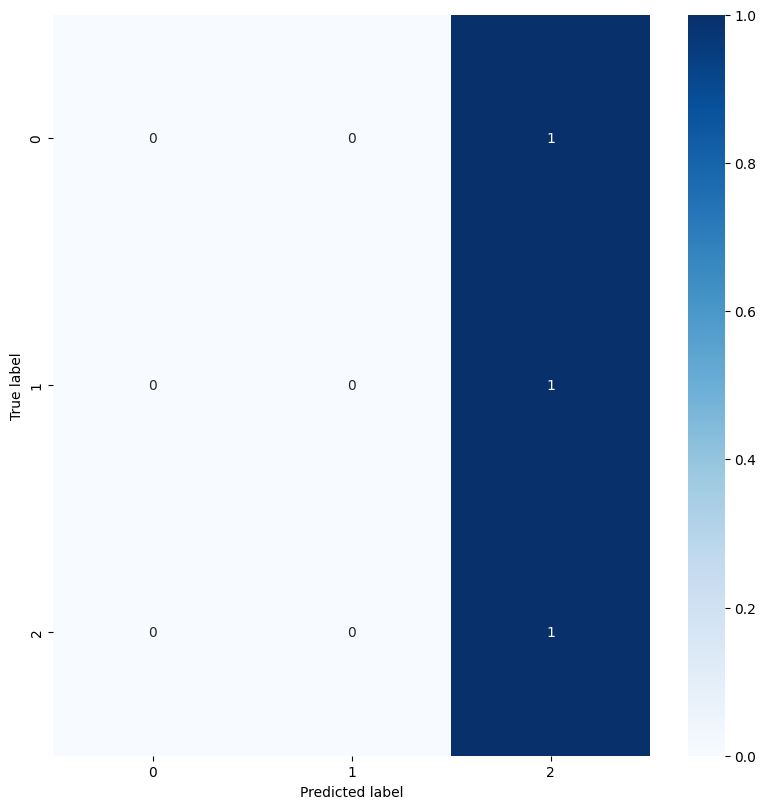

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')  
plt.xlabel('Predicted label')
plt.show()

In [ ]:
acc = (con_mat[0][0] + con_mat[1][1]) / (con_mat[0][0] + con_mat[0][1] + con_mat[1][0] + con_mat[1][1]) 
print('Accuracy when predicting based on best threshold: %f' % acc)

Accuracy when predicting based on best threshold: nan


C:\Users\MOhanad\AppData\Local\Temp\1\ipykernel_4412\3964475311.py:1: RuntimeWarning: invalid value encountered in long_scalars
  acc = (con_mat[0][0] + con_mat[1][1]) / (con_mat[0][0] + con_mat[0][1] + con_mat[1][0] + con_mat[1][1])
